In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
import seaborn as sns
import yfinance as yf

from pykrx import stock
from arch import arch_model

In [62]:
ks200 = stock.get_index_ohlcv("19990101", "20220328", '1028')[['종가']].rename(columns={'종가':'Close'})
ks_vol = ks200.pct_change().dropna().rolling(30).std().apply(lambda x : x * np.sqrt(252) * 100).rename(columns={'Close':'Vol'}).dropna()

ks_vol = ks_vol.iloc[-1000:]

정상성 검정

In [63]:
ts.adfuller(ks_vol, 1)

(-2.4059447368171742,
 0.140065575828265,
 1,
 998,
 {'1%': -3.4369193380671, '5%': -2.864440383452517, '10%': -2.56831430323573},
 2544.953986216796)

use GARCH

Iteration:      1,   Func. Count:      5,   Neg. LLF: 23168.852816499093
Iteration:      2,   Func. Count:     11,   Neg. LLF: 3400.0118571353873
Iteration:      3,   Func. Count:     15,   Neg. LLF: 3399.9666430680536
Iteration:      4,   Func. Count:     19,   Neg. LLF: 3399.8384974039636
Iteration:      5,   Func. Count:     23,   Neg. LLF: 3399.8190941350276
Iteration:      6,   Func. Count:     27,   Neg. LLF: 3399.818851484096
Iteration:      7,   Func. Count:     31,   Neg. LLF: 3399.8181779598635
Iteration:      8,   Func. Count:     35,   Neg. LLF: 3399.8164618177007
Iteration:      9,   Func. Count:     39,   Neg. LLF: 3399.8127691953077
Iteration:     10,   Func. Count:     43,   Neg. LLF: 3399.8058657347447
Iteration:     11,   Func. Count:     47,   Neg. LLF: 3399.7976996815655
Iteration:     12,   Func. Count:     51,   Neg. LLF: 3399.7936015384457
Iteration:     13,   Func. Count:     55,   Neg. LLF: 3399.792720604095
Iteration:     14,   Func. Count:     59,   Neg. LLF:

/opt/homebrew/Caskroom/miniforge/base/envs/quant/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


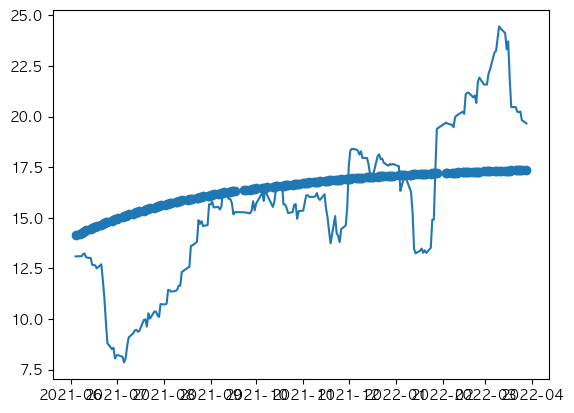

In [70]:
n_test = 200
train, test = ks_vol[:-n_test], ks_vol[-n_test:]

model = arch_model(train, mean='Zero', vol='GARCH', p=1, q=1)
fitted = model.fit()

fitted.summary()
reg = fitted.forecast(horizon=n_test)

y_hat = np.sqrt(reg.variance.values[-1,:])


plt.scatter(x = test.index, y = y_hat)
plt.plot(test)

In [71]:
fitted.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                    Vol   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -3399.79
Distribution:                  Normal   AIC:                           6805.59
Method:            Maximum Likelihood   BIC:                           6819.64
                                        No. Observations:                  800
Date:                Wed, Mar 29 2023   Df Residuals:                      800
Time:                        16:42:44   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          3.8659      1.898      2.037  4.167e-02      [  0.146,  7.586]
alpha[1]       0.9875  4.270e-02     23.127 2.491e-118      [  0.904,  1.071]
beta[1]    1.8130e-18  4.346e-02  4.172e-17      1.000 [-8.517e-02,8.517e-02]
=============================================================================

Covariance estimator: robust
"""